# CNN Keras - Hyperparameter Optimization
Source: https://www.kaggle.com/code/imeintanis/tutorial-cnn-keras-hyper-parameter-opt-w-b-p2


In [12]:
import os 
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import gc

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import *

import tensorflow_addons as tfa

import wandb
from wandb.keras import WandbCallback

## Helpers

In [13]:
# Load the data
def load_data(path):

    train = pd.read_csv("train.csv")
    test = pd.read_csv("test.csv")
    
    x_tr = train.drop(labels=["label"], axis=1)
    y_tr = train["label"]
    
    print(f'Train: we have {x_tr.shape[0]} images with {x_tr.shape[1]} features and {y_tr.nunique()} classes')
    print(f'Test: we have {test.shape[0]} images with {test.shape[1]} features')
    
    return x_tr, y_tr, test


def seed_all(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

# CNN Model

#### Architecture 1 - a simple CNN architecture build with the Keras Functional API (TF backend). The main building blocks and their usage are:

- Convolutional (Conv2D) layer: It is like a set of learnable filters. I choosed to set 32 filters for the first two layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image. The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

- Pooling (MaxPool2D) layer: This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

- Dropout: is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

- Activation function: 'relu' is the rectifier activation function, used to add non linearity to the model.

- Flatten layer: is used to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

- Fully-Connected (Dense) layers: to act as a (NN) classifier. Note that in the last layer (Dense(10,activation="softmax")) the net outputs distribution of probability of each class.


#### Architecture 2 - LeNet5 with some tweaks by C.Deotte (see credits)

In [14]:
# Build CNN model 
# CNN architechture: In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

def build_model(config):
    
    fs = config.filters         # 32
    k1 = config.kernel_1        #[(5,5), (3,3)]
    k2 = config.kernel_2        # [(5,5), (3,3)]
    pad = config.padding
    activ = config.activation   # 'relu'
    pool = config.pooling       # (2,2)
    dp = config.dropout         # 0.25
    dp_out = config.dropout_f   # 0.5
    dense_units = config.dense_units  # 256
    batch_norm = False
    
    inp = Input(shape=(28,28,1))    # IMG_H, IMG_W, NO_CHANNELS
    
    # layer-1:: CNN-CNN-(BN)-Pool-dp
    x = Conv2D(filters=fs, kernel_size=k1, padding=pad, activation=activ)(inp)
    x = Conv2D(filters=fs, kernel_size=k1, padding=pad, activation=activ)(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Dropout(dp)(x)    
    
    # layer-2:: CNN-CNN-(BN)-Pool-dp
    x = Conv2D(filters=fs*2, kernel_size=k2, padding=pad, activation=activ)(inp)
    x = Conv2D(filters=fs*2, kernel_size=k2, padding=pad, activation=activ)(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
    x = Dropout(dp)(x)  
    
    x = Flatten()(x)
    #     x = GlobalAveragePooling2D()(x)
    
    # FC head
    x = Dense(dense_units, activation=activ)(x)
    x = Dropout(dp_out)(x)
    
    out = Dense(10, activation="softmax")(x)
    
    model = tf.keras.models.Model(inp, out)
    
    print(model.summary())
    return model

In [15]:
def build_lenet(config):
    
    fs = config.filters       # 32     
    k1 = config.kernel_1      # 3  
    k2 = config.kernel_2          
    pad = config.padding
    activ = config.activation     
    dp = config.dropout           
    
    inp = Input(shape=(28,28,1))  # (IMG_H, IMG_W, NO_CHANNELS)
    
    x = Conv2D(fs, kernel_size = k1, activation=activ)(inp)
    x = BatchNormalization()(x)
    x = Conv2D(fs, kernel_size = k1, activation=activ)(x)
    x = BatchNormalization()(x)
    x = Conv2D(fs, kernel_size = 5, strides=2, padding='same', activation=activ)(x)
    x = BatchNormalization()(x)
    x = Dropout(dp)(x)
    
    x = Conv2D(fs*2, kernel_size = k1, activation=activ)(x)
    x = BatchNormalization()(x)
    x = Conv2D(fs*2, kernel_size = k1, activation=activ)(x)
    x = BatchNormalization()(x)
    x = Conv2D(fs*2, kernel_size = 5, strides=2, padding='same', activation=activ)(x)
    x = BatchNormalization()(x)
    x = Dropout(dp)(x)
    
    x = Conv2D(fs*4, kernel_size = 4, activation=activ)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(dp)(x)
    
    out = Dense(10, activation='softmax')(x)
    
    model = tf.keras.models.Model(inp, out)

    print(model.summary())
    return model

## Master Params

I use the master variable DEBUG to control the no. of epochs per trial and hence the runtime of the commit.

- set `DEBUG = True` in case of setup/testing/debugging

- set `DEBUG = False` when you ready to run experiments

In [16]:
DEBUG = True          # set to True in case of setup/testing/debugging -- False when you ready to run experiments
# DATA_AUGM = False   # set to True if you wish to add data augmentation 

BATCH_SIZE = 64

if DEBUG:
    EPOCHS = 3          
else: 
    EPOCHS = 40

### 4. Login to W&B

From the command line or inside a nb cell run `!wandb login <your_API_key>` to login and initiate W&B

or, use the `wandb.login()` function and copy and paste the API key when asked

In [17]:
api_key = 'a4246e578f63858d43450e8c00a059390a2b24fd'

In [18]:
!wandb login $api_key

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\jbickelhaupt/.netrc


### 5. Create the W&B configuration

Let's make a dictionary with all the hyperparameters that we'd like to track! For CNN type models I usually keep track of the following params:

- filters
- kernel size
- learning rate (init)
- optimizer
- dense units
- dropout rate etc

But you can add as many others you like.

In [19]:
hyperparams = dict(
     filters = 32,
     kernel_1 = (5,5),
     kernel_2 = (3,3),
     padding = 'same',
     pooling = (2,2),
     lr = 0.001,
     wd = 0.0,
     lr_schedule = 'RLR',    # cos, cyclic, step decay
     optimizer = 'Adam',     # RMS
     dense_units=256,
     activation='relu',      # elu, LeakyRelu
     dropout = 0.25,
     dropout_f = 0.5,
     batch_size = BATCH_SIZE,
     epochs = EPOCHS,
 )

wandb.init(project="mnist_sweep", config=hyperparams)
config = wandb.config

Next, we need to put in a single function all the modelling pipeline, i.e.

- the data loading,
- preprocessing,
- model building and
- training parts

In [23]:
def train():
    
    
    hyperparams = dict(
        filters=32,
        kernel_1=(5,5),
        kernel_2=(3,3),
        padding='same',
        pooling=(2,2),
        lr=0.001,
        wd=0.0,
        lr_schedule='RLR',    # cos, cyclic, step decay
        optimizer='Adam',     # 'RMS'
        dense_units=256,
        activation='relu',      # elu, LeakyRelu
        dropout=0.25,
        dropout_f=0.5,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS)
    
    wandb.init(project="kaggle-mnist", config=hyperparams)
    config = wandb.config
    
    
    SEED = 26
    seed_all(SEED)
    
    #     # Define image sizes and reshape to a 3-dim tensor
    #     global
    IMG_H, IMG_W = 28, 28
    NO_CHANNELS = 1           # for greyscale images
    
    # load data
    x_train, y_train, x_test = load_data(path="../input/digit-recognizer/")
    
    
    # Normalize the data
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    # Reshape to a 4-dim tensor
    x_train = x_train.values.reshape(-1, IMG_H, IMG_W, NO_CHANNELS)
    x_test = x_test.values.reshape(-1, IMG_H, IMG_W, NO_CHANNELS)
    
    # Encode labels
    y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=10)

    print('Tensor shape (train): ', x_train.shape)
    print('Tensor shape (test): ', x_test.shape)
    print('Tensor shape (target ohe): ', y_train_ohe.shape)
    
    # Split the train and the validation set for the fitting
    x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train_ohe, test_size=0.15, random_state=SEED)
    
    print('Tensors shape (train):', x_tr.shape, y_tr.shape)
    print('Tensors shape (valid):', x_val.shape, y_val.shape)
    
    print('Build architecture 1')
    model = build_model(config=config)
    
#     print('Build architecture 2 - LeNet5')
#     model = build_lenet(config=config)
    
    
    # Define the optimizer
    if config.optimizer=='Adam':
        opt = Adam(config.lr)
    elif config.optimizer=='RMS':
        opt = RMSprop(lr=config.lr, rho=0.9, epsilon=1e-08, decay=0.0)
    elif config.optimizer=='Adam+SWA':
        opt = Adam(LR)
        opt = tfa.optimizers.SWA(opt)
    else: 
        opt = 'adam'    # native adam optimizer 
    
    
    # Compile the model
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    
    # Set callbacks

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, verbose=1), 
        ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose=1, factor=0.5, min_lr=1e-4),
        WandbCallback(monitor='val_loss', validation_data=(x_val, y_val))]  
    
    model.fit(x_train, y_train_ohe, 
                     batch_size=config.batch_size,    # BATCH_SIZE, 
                     epochs=config.epochs,            # EPOCHS, 
                     validation_data=(x_val, y_val), 
                     callbacks=callbacks,
                     verbose=1) 

# Hyperparameter Optimization


### Method 1

Build the sweep (hyperparameter search) configuration with python dict.

The sweeps config can be defined as a dictionary or a YAML file. Let's walk through some of them together:

- `Metric` – This is the metric the sweeps are attempting to optimize. Metrics can take a name (this metric should be logged by your training script) and a goal (maximize or minimize).

- `Search Strategy` – Specified using the 'method' variable. We support several different search strategies with sweeps.

    - `Grid Search` – Iterates over every combination of hyperparameter values.
    - `Random Search` – Iterates over randomly chosen combinations of hyperparameter values.
    - `Bayesian Search` – Creates a probabilistic model that maps hyperparameters to probability of a metric score, and chooses parameters with high probability of improving the metric. The objective of Bayesian optimization is to spend more time in picking the hyperparameter values, but in doing so trying out fewer hyperparameter values.
    - `Stopping Criteria` – The strategy for determining when to kill off poorly peforming runs, and try more combinations faster. We offer several custom scheduling algorithms like HyperBand and Envelope.

- `Parameters` – A dictionary containing the hyperparameter names, and discreet values, max and min values or distributions from which to pull their values to sweep over.

In [24]:
sweep_config = {
#     'program': 'train.py',     # 'tutorial-cnn-keras-hyperparameter-opt-w-b-p2.ipynb',
    'method': 'random',         # 'grid', 'hyperopt', 'bayesian'
    'metric': {
        'name': 'val_loss',     # or 'val_accuracy'
        'goal': 'minimize'      # 'maximize'
    },
    'parameters': {
        'filters': {
            'values': [16, 32, 64]
        },
        'lr': {
            'distribution': 'uniform',
            'min': 0.0005,
            'max': 0.002
        },
        'dp': {
            'values': [0.4, 0.5]
        }
    }
}

Initialize the sweep by running `wandb.sweep()`. This returns the `sweep_id` that we use to run the sweep agent.

In [21]:
sweep_id = wandb.sweep(sweep_config, project='mnist_sweep')

Create sweep with ID: qzdovl0h
Sweep URL: https://wandb.ai/jrbickelhaupt/mnist_sweep/sweeps/qzdovl0h


Start the agent running with `wandb.agent()`

(here, I limit the number of trial runs using the `count` arg)

In [25]:
wandb.agent(sweep_id, function=train, count=3, project='mnist_sweep')   #

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: tch9lns7 with config:
wandb: 	dp: 0.4
wandb: 	filters: 16
wandb: 	lr: 0.0012377651271698778
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train: we have 42000 images with 784 features and 10 classes
Test: we have 28000 images with 784 features
Tensor shape (train):  (42000, 28, 28, 1)
Tensor shape (test):  (28000, 28, 28, 1)
Tensor shape (target ohe):  (42000, 10)
Tensors shape (train): (35700, 28, 28, 1) (35700, 10)
Tensors shape (valid): (6300, 28, 28, 1) (6300, 10)
Build architecture 1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                               

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


None
Epoch 1/3
657/657 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9334

INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_075933-tch9lns7\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_075933-tch9lns7\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_075933-tch9lns7\files\model-best)... Done. 0.0s


657/657 [==============================] - 9s 10ms/step - loss: 0.2161 - accuracy: 0.9334 - val_loss: 0.0481 - val_accuracy: 0.9851 - lr: 0.0012
Epoch 2/3
656/657 [============================>.] - ETA: 0s - loss: 0.0788 - accuracy: 0.9760

INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_075933-tch9lns7\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_075933-tch9lns7\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_075933-tch9lns7\files\model-best)... Done. 0.0s


657/657 [==============================] - 6s 9ms/step - loss: 0.0788 - accuracy: 0.9760 - val_loss: 0.0278 - val_accuracy: 0.9914 - lr: 0.0012
Epoch 3/3
655/657 [============================>.] - ETA: 0s - loss: 0.0581 - accuracy: 0.9820

INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_075933-tch9lns7\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_075933-tch9lns7\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_075933-tch9lns7\files\model-best)... Done. 0.0s


657/657 [==============================] - 6s 9ms/step - loss: 0.0581 - accuracy: 0.9820 - val_loss: 0.0173 - val_accuracy: 0.9943 - lr: 0.0012


accuracy,▁▇█
epoch,▁▅█
loss,█▂▁
lr,▁▁▁
val_accuracy,▁▆█
val_loss,█▃▁
accuracy,0.98202
best_epoch,2
best_val_loss,0.01732
epoch,2
loss,0.05806


wandb: Agent Starting Run: 77jmqtzg with config:
wandb: 	dp: 0.5
wandb: 	filters: 16
wandb: 	lr: 0.001306298188824392
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train: we have 42000 images with 784 features and 10 classes
Test: we have 28000 images with 784 features
Tensor shape (train):  (42000, 28, 28, 1)
Tensor shape (test):  (28000, 28, 28, 1)
Tensor shape (target ohe):  (42000, 10)
Tensors shape (train): (35700, 28, 28, 1) (35700, 10)
Tensors shape (valid): (6300, 28, 28, 1) (6300, 10)
Build architecture 1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                               

INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080014-77jmqtzg\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080014-77jmqtzg\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080014-77jmqtzg\files\model-best)... Done. 0.0s


657/657 [==============================] - 6s 9ms/step - loss: 0.2006 - accuracy: 0.9382 - val_loss: 0.0452 - val_accuracy: 0.9868 - lr: 0.0013
Epoch 2/3
650/657 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9781

INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080014-77jmqtzg\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080014-77jmqtzg\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080014-77jmqtzg\files\model-best)... Done. 0.0s


657/657 [==============================] - 6s 9ms/step - loss: 0.0730 - accuracy: 0.9782 - val_loss: 0.0291 - val_accuracy: 0.9910 - lr: 0.0013
Epoch 3/3
653/657 [============================>.] - ETA: 0s - loss: 0.0540 - accuracy: 0.9831

INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080014-77jmqtzg\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080014-77jmqtzg\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080014-77jmqtzg\files\model-best)... Done. 0.0s


657/657 [==============================] - 6s 9ms/step - loss: 0.0539 - accuracy: 0.9831 - val_loss: 0.0184 - val_accuracy: 0.9944 - lr: 0.0013


accuracy,▁▇█
epoch,▁▅█
loss,█▂▁
lr,▁▁▁
val_accuracy,▁▅█
val_loss,█▄▁
accuracy,0.98314
best_epoch,2
best_val_loss,0.01841
epoch,2
loss,0.05394


wandb: Agent Starting Run: ic40s063 with config:
wandb: 	dp: 0.4
wandb: 	filters: 16
wandb: 	lr: 0.0018569263469961584
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Train: we have 42000 images with 784 features and 10 classes
Test: we have 28000 images with 784 features
Tensor shape (train):  (42000, 28, 28, 1)
Tensor shape (test):  (28000, 28, 28, 1)
Tensor shape (target ohe):  (42000, 10)
Tensors shape (train): (35700, 28, 28, 1) (35700, 10)
Tensors shape (valid): (6300, 28, 28, 1) (6300, 10)
Build architecture 1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                               

INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080049-ic40s063\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080049-ic40s063\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080049-ic40s063\files\model-best)... Done. 0.0s


657/657 [==============================] - 7s 9ms/step - loss: 0.1945 - accuracy: 0.9401 - val_loss: 0.0473 - val_accuracy: 0.9852 - lr: 0.0019
Epoch 2/3
650/657 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9775

INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080049-ic40s063\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080049-ic40s063\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080049-ic40s063\files\model-best)... Done. 0.0s


657/657 [==============================] - 6s 9ms/step - loss: 0.0736 - accuracy: 0.9776 - val_loss: 0.0322 - val_accuracy: 0.9884 - lr: 0.0019
Epoch 3/3
657/657 [==============================] - ETA: 0s - loss: 0.0548 - accuracy: 0.9828

INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080049-ic40s063\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080049-ic40s063\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\jbickelhaupt\Downloads\MNIST-main (1)\MNIST-main\wandb\run-20230112_080049-ic40s063\files\model-best)... Done. 0.0s


657/657 [==============================] - 6s 9ms/step - loss: 0.0548 - accuracy: 0.9828 - val_loss: 0.0174 - val_accuracy: 0.9940 - lr: 0.0019


accuracy,▁▇█
epoch,▁▅█
loss,█▂▁
lr,▁▁▁
val_accuracy,▁▄█
val_loss,█▄▁
accuracy,0.98279
best_epoch,2
best_val_loss,0.0174
epoch,2
loss,0.05479


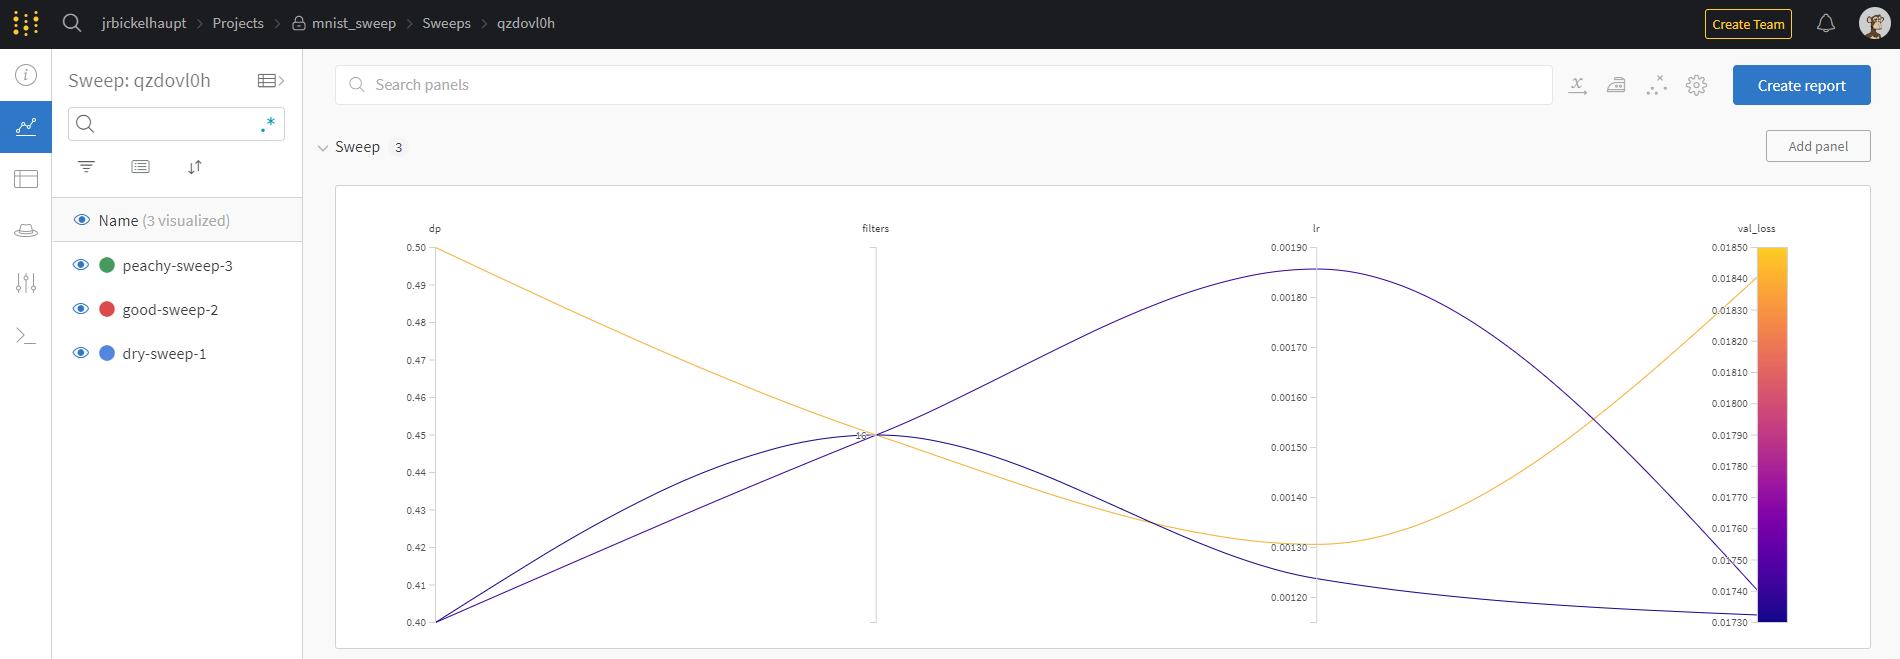